# Unconditional stochastic simulation using Cholesky decomposition

The aim of this document is to show and test how to generate realizations of a Gaussian process using Cholesky decomposition. 

The theory is available in different references :
- Kitanidis, P., 1996, Introduction to geostatistics. p.237
- Marcotte, D., 2006, Cours de géostatistique

Author: P. Renard / December 2017

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

##  Defines the geometry of the problem

For this example, the geometry that is considered is a one dimensional regular and cartesian grid. The number of nodes $n$ is given.

In [2]:
n = 139*2  # Number of nodes

x = np.linspace(0, 200, n)  # Creates n regular coordinates from 0 to 200
X = np.zeros((n,2))         # Assembles these values as a 2 D coordinate matrix to be abble to use pdist
X[:,0] = x
D = squareform( pdist(X) )  # Computes the distance matrix between all nodes

## Defines the covariance of the Gaussian process

The user can provide the range (a) and sill (sigma2) of the covariance. The formula computes the covariance matrix between all the nodes of the grid.

In [3]:
sigma2 = 1; # Variance = Sill
a = 5       # Range that is fine for a gaussian covariance
a = 100

# Gaussian covariance
#C = sigma2 * np.exp( -3 * np.power( D/a, 2) ) 

# Exponential covariance
C = sigma2 * np.exp( -3 * np.abs( D/a ) ) 

# Spherical covariance
#C = np.zeros((n,n))
#range_tmp = D<=a
#C[range_tmp] = sigma2 * (1 - 3/2*D[range_tmp]/a + 1/2*np.power(D[range_tmp]/a,3))



## Generates one simulation

First, the covariance matrix is decomposed using Cholesky technique. 

$$ C = L  L^T$$

We get the lower part $L$ of the decomposition. Note that depending on the covariance and number of grid cells, the Cholesky decomposition may not converge because of round-off errors. 

If everything goes well, one has only to multiply the matrix $L$ by a vector $r$ of uncorrelated random normal values to obtain the result $y$. 
$$ y = L r $$ 

In [4]:
L = np.linalg.cholesky( C )
r = np.random.randn( n, 1 )
y = np.dot( L, r)

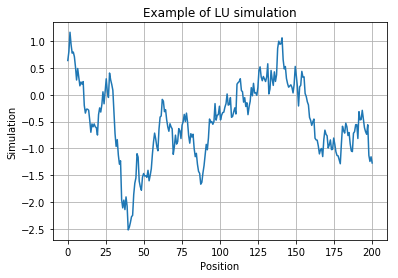

In [5]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set(xlabel='Position', ylabel='Simulation',
       title='Example of LU simulation')
ax.grid()
plt.show()

## Prepares a conditioning data set

We just select $nc$ points randomly and get the $y$ values from the previous unconditionnal stochastic realization.


In [6]:
nc = 10 # 
nsimuls = 500
permutation = np.random.permutation( n ) 
# Picks nc values from a random permutation among n
i = np.unique( permutation[0:nc] ) 
z1 = y[i,0] # Picks the corresponding y values
z1.shape = (nc,1)


## Generates a conditional simulation

The technique consists in splitting the covariance matrix and ensuring that the values at the conditioning location are respected. 


In [7]:
# Defines the "free" positions in the covariance matrix - complement of i
j = np.arange(n) 
j = np.delete( j, i )

# In the following lines, the covariance matrix is reorganized.
# The lines and rows corresponding to the data are moved in the upper left corner.
# The result is a new covariance matrix K.

K = np.zeros( (n, n) )
K[0:nc, 0:nc] = C[ np.ix_(i, i) ]
K[0:nc, nc:n] = C[ np.ix_(i, j) ]
K[nc:n, 0:nc] = C[ np.ix_(j, i) ]
K[nc:n, nc:n] = C[ np.ix_(j, j) ]

# Here we apply the Cholesky decomposition with the usual restrictions.

L = np.linalg.cholesky( K )

# And extract the parts related to the data and unknown locations.

L11 = L[0:nc, 0:nc]    # Data to data
L21 = L[nc:n, 0:nc]    # Data to unknown
L22 = L[nc:n, nc:n]    # Unknown to unknown

# To ensure conditionning, one has to force the deterministic part

Lc = np.dot(L21, np.linalg.inv( L11 ))

# Generation of the stochastic realization (deterministic + random part)

r = np.random.randn( n-nc, nsimuls )
z2 = np.dot( Lc, z1) + np.dot( L22, r)

# Assemble the results in the right order for plotting

yc = np.zeros( (n,nsimuls) )
yc[i,0:nsimuls] = z1
yc[j,0:nsimuls] = z2

# Computes the statistics among the ensemble

ycstd = np.std( yc, axis = 1 )
ymean = np.mean( yc, axis = 1 )
ycmax = np.percentile( yc, 99.5, axis = 1)
ycmin = np.percentile( yc, 0.5, axis = 1)

## Plot the results

We first plot the simulations, and then a single realization with the confidence intervals around the mean.

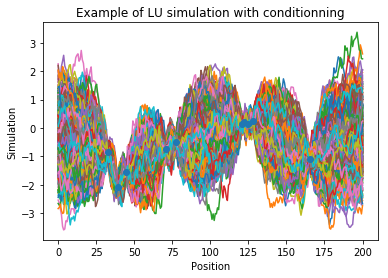

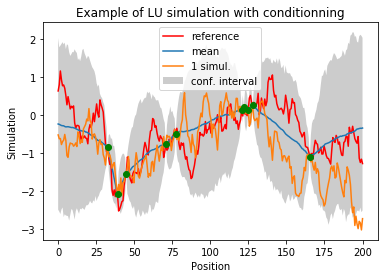

In [8]:
# Plot the conditional realizations
fig, ax = plt.subplots()
ax.plot(x, yc,x[i],z1,'o')
ax.set(xlabel='Position', ylabel='Simulation',
       title='Example of LU simulation with conditionning')
plt.show()


# Plot the enveloppe of the confidence interval
fig, ax = plt.subplots()
ax.plot(x,y[:,0],'r',label='reference')
ax.plot(x, ymean, label='mean')
ax.fill_between(x, ycmin, ycmax, facecolor='gray', 
                alpha=0.4, label='conf. interval')
ax.plot(x, yc[:,1],label='1 simul.')
ax.plot(x[i],z1,'og')
ax.set(xlabel='Position', ylabel='Simulation',
       title='Example of LU simulation with conditionning')
ax.legend(loc='best')
plt.show()